In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor, VotingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import plotly
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objs as go
pyo.init_notebook_mode()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
dataset = pd.read_csv("data/train_house.csv")
test = pd.read_csv("data/test_house.csv")

# House Prices

In [5]:
dataset.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

**Размер датасета**

In [6]:
dataset.shape

(1460, 81)

**Названия столбцов**

In [7]:
columns = dataset.columns
columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Анализ предсказываемой переменной

**Проверка переменной на нулевые значения**

In [8]:
dataset['SalePrice'].isnull().sum()

0

**Распределение цены продажи**

Text(0.5, 1.0, 'Распределение цены')

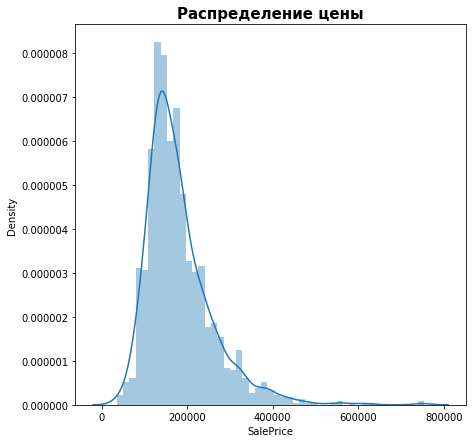

In [9]:
plt.figure(figsize=(7,7))
sns.distplot(dataset['SalePrice'])
plt.title("Распределение цены",size=15, weight='bold')

**Описание предсказываемой переменной:**

In [10]:
dataset['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

**Преобразование предсказываемой переменной**

Иногда при построении регрессии целесообразно преобразовать зависимую переменную у. Прогнозирование частот является довольно распространенной задачей, и преобразование log(у + 1) часто помогает

Для этого будет использоваться функция numpy.log:

*The natural logarithm log is the inverse of the exponential function, so that log(exp(x)) = x. The natural logarithm is logarithm in base e.*

In [11]:
dataset['SalePrice_log'] = np.log(dataset['SalePrice']+1)
average_price = dataset.pop('SalePrice')

Text(0.5, 1.0, 'Логарифмическое распределение цены')

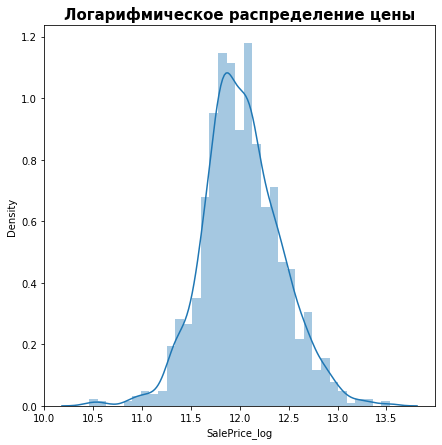

In [64]:
plt.figure(figsize=(7,7))
sns.distplot((dataset['SalePrice_log']))
plt.title("Логарифмическое распределение цены", size=15, weight='bold')

**Результат**
- Минимальная цена продажи в данном датасете равна 34900
- Максимальная цена продажи равна 755000
- Среднее равно 180921
- Так как цена распределена не равномерно (при перцентиле 25% - 129975, а при 75% 214000), было сделано логарифмическое преобразование переменной

## Анализ всех переменных

In [13]:
columns = dataset.columns
columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [14]:
list(columns).index('Id')

0

**Количество нулевых значений**

In [15]:
dataset.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice_log      0
Length: 81, dtype: int64

**Столбцы с нулевыми значениями**

In [16]:
isnull_columns = [var for var in columns if dataset.isnull().sum()[var]>0]
isnull_columns

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

Можно видеть, что 19 переменных содержат нулевые значения.

**Типы переменных**

In [17]:
list(dataset.dtypes)

[dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype(

В датасете содержатся стролбцы с различными типами данных, необходимо выделить количественные и качественные переменные.

In [18]:
columns = dataset.columns

**Количество качественных переменных**

In [19]:
categorical = [var for var in columns if dataset[var].dtype=='object']
print('Датасет содержит', len(categorical), 'качественных переменных:\n', categorical)

Датасет содержит 43 качественных переменных:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


**Количество количественных переменных**

In [22]:
numerical = [var for var in columns if ((dataset[var].dtype=='float64')|(dataset[var].dtype=='int64'))]
print('Датасет содержит', len(numerical), 'количественных переменных:\n', numerical)

Датасет содержит 38 количественных переменных:
 ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice_log']


### Анализ качественных переменных

Датасет содержит 43 качественных переменных.


**Количество категорий в каждой переменной**

Для того, чтобы построить понятные графики с количеством значений в переменных, необходимо отделить переменные, где много уникальных значений (в данном случае больше 10).

In [20]:
for cat in categorical:
    if (len(dataset[cat].unique())>10):
        print(cat, 'содержит', len(dataset[cat].unique()), 'уникальных переменных')

Neighborhood содержит 25 уникальных переменных
Exterior1st содержит 15 уникальных переменных
Exterior2nd содержит 16 уникальных переменных


Создание списка с переменными, где много уникальных значений, для фильтрации при построении графиков.

In [22]:
categorical_big = ['Neighborhood', 'Exterior1st', 'Exterior2nd']

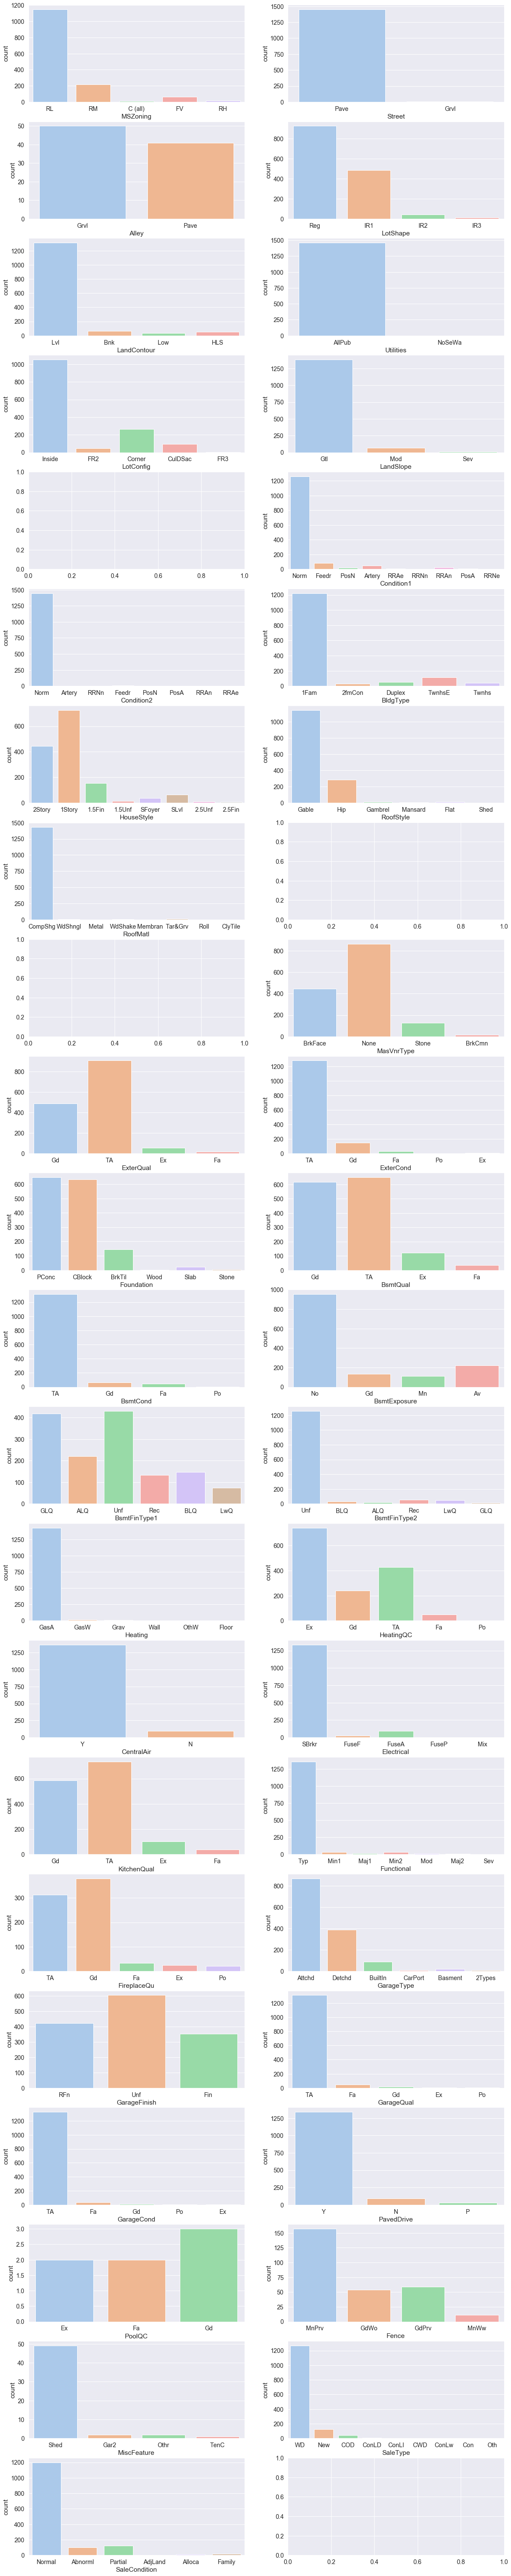

In [23]:
sns.set(font_scale=1.3)
f, axes = plt.subplots(22, 2, figsize=(20, 110))
val = 0
try:
    for i in range(22):
        for j in range(2):
            if ((categorical[val] in categorical_big)):
                val+=1
                continue
            sns.countplot(
                x=categorical[val], 
                palette="pastel", 
                data=dataset, 
                ax=axes[i, j]) 
            val+=1
except IndexError: # catch the error
    pass

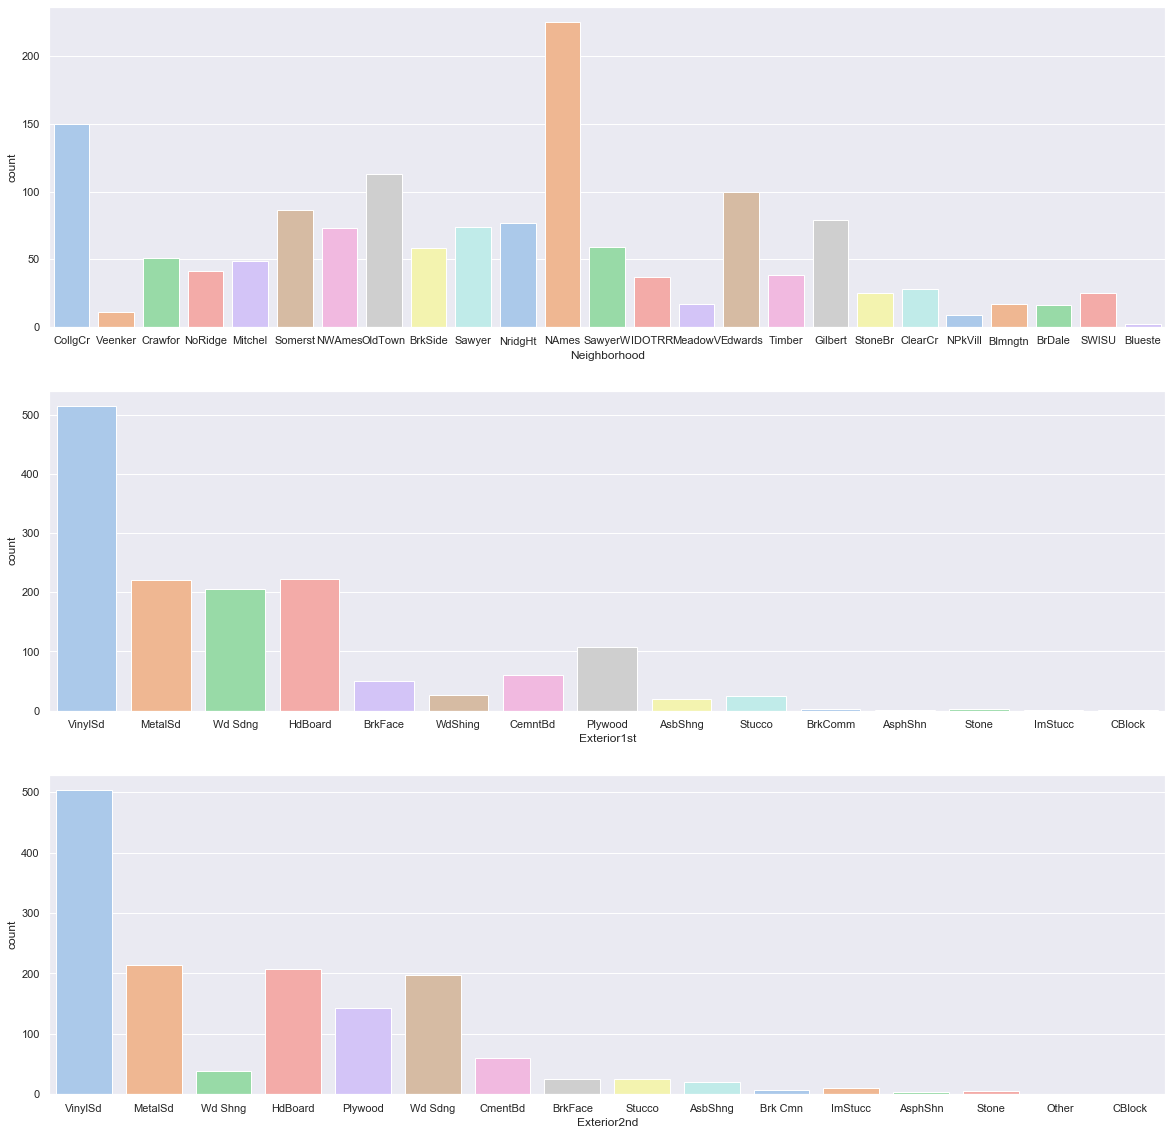

In [24]:
sns.set(font_scale=1)
f, axes = plt.subplots(3, 1, figsize=(20, 20))
try:
    for i in range(3):
        sns.countplot(
                x=categorical[categorical.index(categorical_big[i])], 
                palette="pastel", 
                data=dataset, 
                ax=axes[i]) 
        
except IndexError: # catch the error
    pass

**Количество значений в каждой категории в каждой переменной**

In [25]:
for cat in categorical:
    print(dataset[cat].value_counts(), '\n')

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64 

Pave    1454
Grvl       6
Name: Street, dtype: int64 

Grvl    50
Pave    41
Name: Alley, dtype: int64 

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64 

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64 

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64 

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64 

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64 

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neig

**Распределение категорий в каждой переменной**

In [26]:
for cat in categorical:
    print(dataset[cat].value_counts()/len(dataset)*100, '\n')

RL         78.835616
RM         14.931507
FV          4.452055
RH          1.095890
C (all)     0.684932
Name: MSZoning, dtype: float64 

Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64 

Grvl    3.424658
Pave    2.808219
Name: Alley, dtype: float64 

Reg    63.356164
IR1    33.150685
IR2     2.808219
IR3     0.684932
Name: LotShape, dtype: float64 

Lvl    89.794521
Bnk     4.315068
HLS     3.424658
Low     2.465753
Name: LandContour, dtype: float64 

AllPub    99.931507
NoSeWa     0.068493
Name: Utilities, dtype: float64 

Inside     72.054795
Corner     18.013699
CulDSac     6.438356
FR2         3.219178
FR3         0.273973
Name: LotConfig, dtype: float64 

Gtl    94.657534
Mod     4.452055
Sev     0.890411
Name: LandSlope, dtype: float64 

NAmes      15.410959
CollgCr    10.273973
OldTown     7.739726
Edwards     6.849315
Somerst     5.890411
Gilbert     5.410959
NridgHt     5.273973
Sawyer      5.068493
NWAmes      5.000000
SawyerW     4.041096
BrkSide     3.9726

### Анализ количественных переменных

**Распределение данных**

Составлен график распределения без разделения по значениям RainTomorrow.

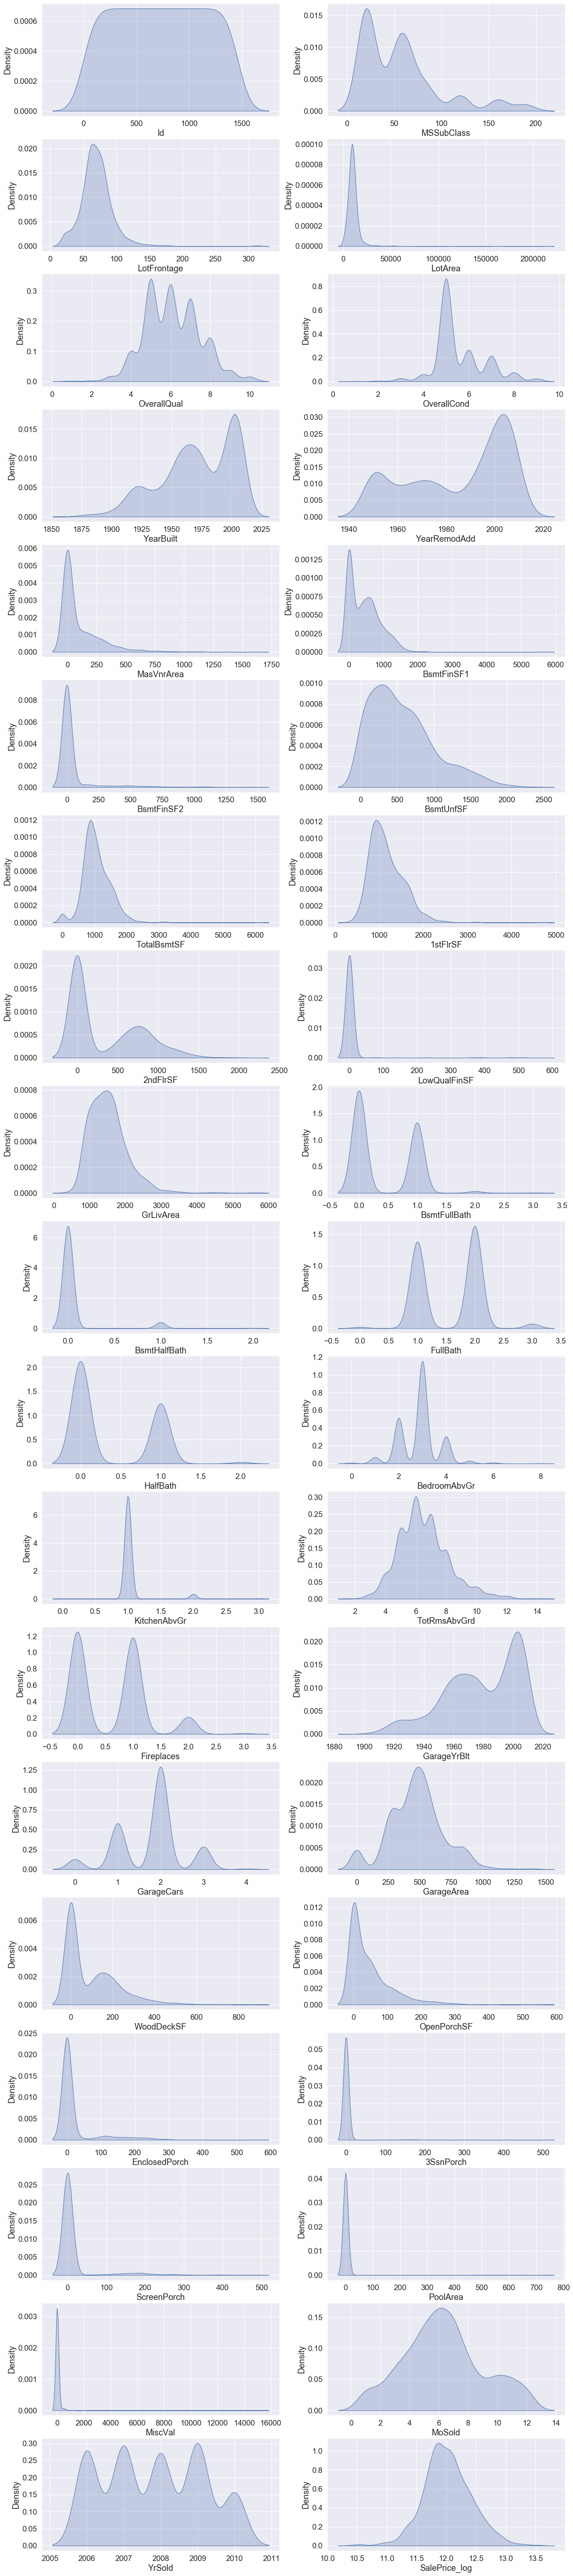

In [27]:
sns.set(font_scale=1.5)
f, axes = plt.subplots(19, 2, figsize=(20, 100))
val = 0
try:
    for i in range(19):
        for j in range(2):
            sns.kdeplot(data = dataset, x=numerical[val], fill=True, ax=axes[i, j], palette="pastel")
            val+=1
            
except IndexError: # catch the error
    pass                

**Количество нулевых значений**

In [28]:
[{var: dataset.isnull().sum()[var]} for var in numerical if dataset.isnull().sum()[var]>0]

[{'LotFrontage': 259}, {'MasVnrArea': 8}, {'GarageYrBlt': 81}]

**Заполнение нулевых значений**

Я заполню нулевые значения медианой, так как есть переменные с выбросами.

In [23]:
for num in numerical:
    median = dataset[num].median()
    dataset[num].fillna(median, inplace=True)
    
dataset[numerical].isnull().sum()

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice_log    0
dtype: int64

### График корреляции

Text(0.5, 1, 'Корреляция между признаками')

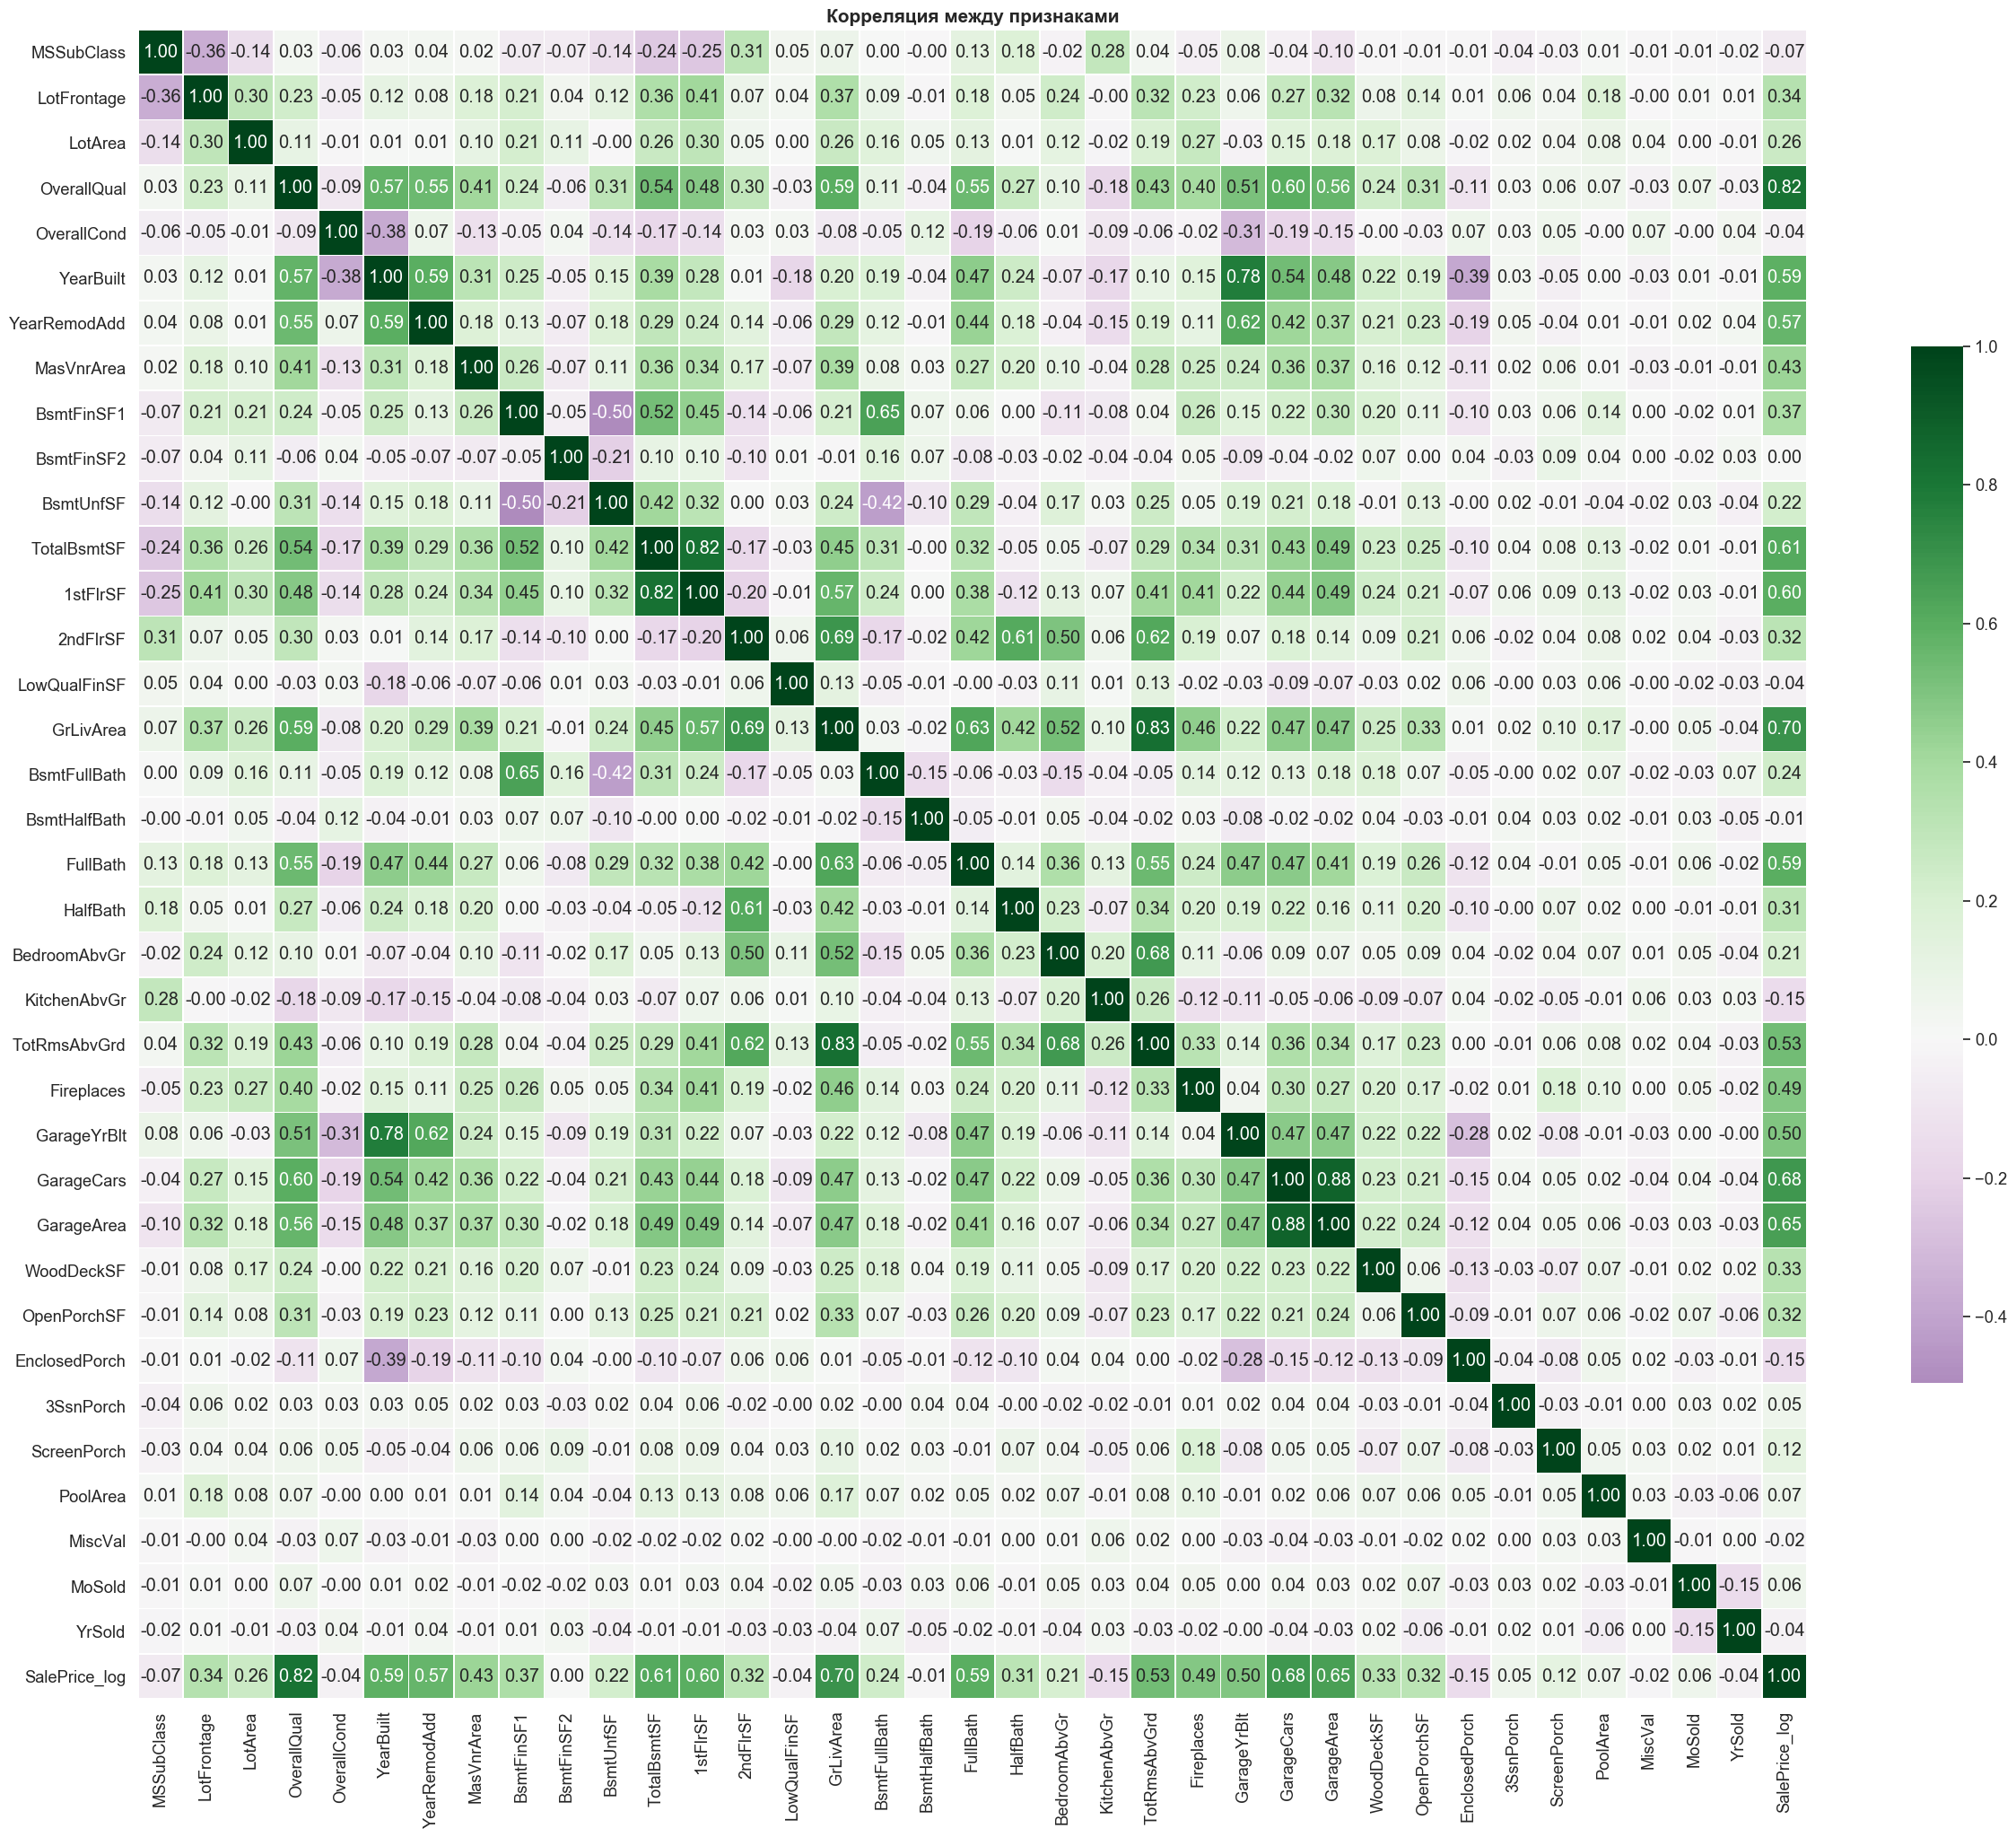

In [49]:
sns.set(font_scale=1.2)
plt.figure(figsize=(30,30))
corr = dataset.drop(['Id'], axis=1).corr(method='pearson') 
sns.heatmap(corr, annot=True, fmt='.2f', cmap='PRGn', vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(corr.shape[0], 0))
plt.title("Корреляция между признаками", size=15, weight='bold')

In [137]:
print('Корреляция более 0.6 есть между этими признаками:')
for col in corr.columns:
    corr_dict = [{var: round(corr[corr[col]>0.6][col][var], 2)} 
                 for var in corr[corr[col]>0.6][col].index
                 if corr[col][var]<1]
    if len(corr_dict)>0: 
        print('\n', col, 'с', len(corr_dict), 'признаками:', corr_dict)

Корреляция более 0.6 есть между этими признаками:

 OverallQual с 2 признаками: [{'GarageCars': 0.6}, {'SalePrice_log': 0.82}]

 YearBuilt с 1 признаками: [{'GarageYrBlt': 0.78}]

 YearRemodAdd с 1 признаками: [{'GarageYrBlt': 0.62}]

 BsmtFinSF1 с 1 признаками: [{'BsmtFullBath': 0.65}]

 TotalBsmtSF с 2 признаками: [{'1stFlrSF': 0.82}, {'SalePrice_log': 0.61}]

 1stFlrSF с 1 признаками: [{'TotalBsmtSF': 0.82}]

 2ndFlrSF с 3 признаками: [{'GrLivArea': 0.69}, {'HalfBath': 0.61}, {'TotRmsAbvGrd': 0.62}]

 GrLivArea с 4 признаками: [{'2ndFlrSF': 0.69}, {'FullBath': 0.63}, {'TotRmsAbvGrd': 0.83}, {'SalePrice_log': 0.7}]

 BsmtFullBath с 1 признаками: [{'BsmtFinSF1': 0.65}]

 FullBath с 1 признаками: [{'GrLivArea': 0.63}]

 HalfBath с 1 признаками: [{'2ndFlrSF': 0.61}]

 BedroomAbvGr с 1 признаками: [{'TotRmsAbvGrd': 0.68}]

 TotRmsAbvGrd с 3 признаками: [{'2ndFlrSF': 0.62}, {'GrLivArea': 0.83}, {'BedroomAbvGr': 0.68}]

 GarageYrBlt с 2 признаками: [{'YearBuilt': 0.78}, {'YearRemodAdd': 0.

Корреляция более 0.8 есть между этими признаками:
- OverallQual, SalePrice_log
- 1stFlrSF, TotalBsmtSF
- TotRmsAbvGrd, GrLivArea
- GarageCars, GarageArea

Корреляция 0.7-0.8 есть между этими признаками:
- GarageYrBlt, YearBuilt
- GrLivArea, SalePrice_log


In [31]:
#Restore the rc params from Matplotlib's internal default style
plt.rcdefaults()

**Создание датасета с One Hot Encoding**

In [24]:
dataset_dummies = pd.get_dummies(dataset.drop(['SalePrice_log'], axis = 1), dummy_na=True)
dataset_dummies.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_Oth  SaleType_WD  \
0          2003       196.0         706  ...             0            1   
1          1976         0.0         978  ...             0            1   
2          2002       162.0         486  ...             0            1   
3          1970         0.0         216  ...             0            1   
4          2000       350.0         655  ...             0            1   

   SaleType_nan  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0                      0                      0   
1             0                      0                      0   
2             0                      0                      0   
3             0                      1                      0   
4             0                      0                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  SaleCondition_nan  
0                      0                  0  
1                      0                  0  
2                      0                  0  
3                      0                  0  
4                      0                  0  

[5 rows x 332 columns]

## Изучение важности критериев

In [25]:
def get_xy(dataset_dummies, dataset):
    x, y = dataset_dummies.iloc[:,:], dataset.iloc[:,-1]
    return x, y


In [26]:
x, y = get_xy(dataset_dummies, dataset)
feature_names = list(dataset_dummies.columns)

**Использование RandomForestClassifier для составления графика важности критериев**

Text(0.5, 1.0, 'RandomForestClassifier feature importances >0.001')

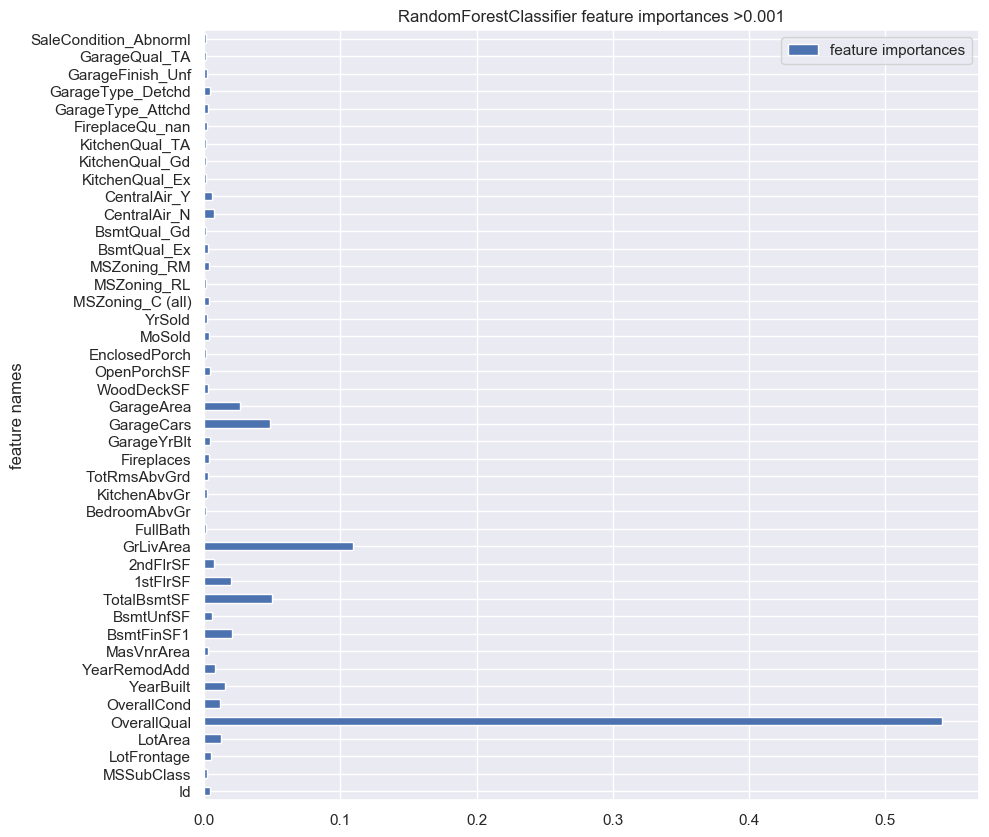

In [139]:
sns.set(font_scale=1)
forest = RandomForestRegressor()
forest.fit(x, y)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'feature importances':forest.feature_importances_})
df_to_plot[df_to_plot['feature importances']>0.001].plot.barh(x='feature names', y='feature importances', figsize=(10, 10))
plt.title('RandomForestClassifier feature importances >0.001')

## Обучение и предсказание

In [27]:
def make_preprossesor(scaler, categorical_features):
    if (categorical_features):
        preprocessor = ColumnTransformer(transformers=[
        ('num', scaler, selector(dtype_exclude="category")),
        ('cat', OneHotEncoder(handle_unknown='ignore'), selector(dtype_include="category"))])
    else:
        preprocessor = scaler                                 
    return preprocessor

In [28]:
def show_results(estimator, scaler, x, y, categorical_features=False):
    preprocessor = make_preprossesor(scaler, categorical_features)                   
    model = Pipeline(steps=[('preprocessor', preprocessor),('estimator', estimator)])  
                                         
    estimatorScores = cross_val_score(model, x, y)
    print("\nРезультат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=5)
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    print('\nMAE: {:.4f}'.format(mean_absolute_error(y_test, model_pred)))
    print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, model_pred))))   
    print('R2 {:.4f}'.format(r2_score(y_test, model_pred)))
    return model

In [29]:
def grid_search(estimator, param_grid, scaler, x, y, categorical_features=False):
    preprocessor = make_preprossesor(scaler, categorical_features)                              
    model = Pipeline(steps=[('preprocessor', preprocessor),('estimator', estimator)])
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=5)
    grid_search = GridSearchCV(model, param_grid)
    grid_search.fit(X_train, y_train)
    print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
    print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
    return grid_search

### Linear Regression

In [30]:
print("Linear Regression")
lin = show_results(LinearRegression(),
                      StandardScaler(),
                      x, y)

Linear Regression

Результат перекрестной проверки: [-1.92020339e+21 -1.37922875e+23 -3.93464738e+21 -4.00119229e+17
 -4.68584404e+22]
Средняя правильность перекрестной проверки: -38127313314848121552896.000

MAE: 87400039781.3676
RMSE: 756749194319.0989
R2 -3489784155803963501838336.0000


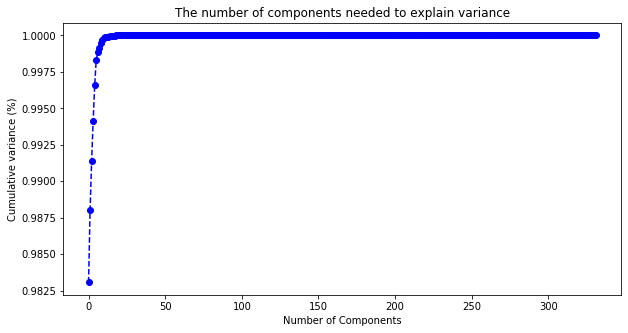

In [31]:
pca = PCA().fit(x)
plt.figure(figsize=(10,5))
y_pca = np.cumsum(pca.explained_variance_ratio_)
plt.plot(y_pca, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.show()

In [202]:
print('PCA grid search with LinearRegression')
param_grid = {
    'estimator__pca__n_components': [10, 20, 30, 50, 100, x.shape[1]//2]}
gsCV = grid_search(Pipeline(steps=[('pca', PCA()),('lin', LinearRegression())]), 
                   param_grid, 
                   StandardScaler(), 
                   x, y)


PCA grid search with LinearRegression
Правильность на тестовом наборе: 0.87
Наилучшие значения параметров: {'estimator__pca__n_components': 100}


In [111]:
print('Ridge with PCA')
lin = show_results(LinearRegression(),
                StandardScaler(),
                PCA(n_components=100).fit_transform(x), y)

Ridge with PCA

Результат перекрестной проверки: [0.90462256 0.86841999 0.88951882 0.89057551 0.77449433]
Средняя правильность перекрестной проверки: 0.866

MAE: 0.0967
RMSE: 0.1338
R2 0.8908


In [205]:
print('Ridge with PCA')
r_lin = show_results(Ridge(),
                StandardScaler(),
                PCA(n_components=100).fit_transform(x), y)

Ridge with PCA

Результат перекрестной проверки: [0.90359672 0.86959641 0.89006017 0.89100456 0.77659174]
Средняя правильность перекрестной проверки: 0.866

MAE: 0.0970
RMSE: 0.1335
R2 0.8913


### Ensembles

**Сравнение различных ансамблей.**

In [153]:
for ensemble in [RandomForestRegressor(), GradientBoostingRegressor(), BaggingRegressor(), AdaBoostRegressor()]:    
    print('\n', ensemble)
    res = show_results(
            ensemble,
            StandardScaler(),
            x, y)


 RandomForestRegressor()

Результат перекрестной проверки: [0.8675761  0.86411311 0.87700183 0.88388345 0.85553485]
Средняя правильность перекрестной проверки: 0.870

MAE: 0.0947
RMSE: 0.1378
R2 0.8843

 GradientBoostingRegressor()

Результат перекрестной проверки: [0.90576297 0.89034223 0.89534071 0.90392575 0.89546068]
Средняя правильность перекрестной проверки: 0.898

MAE: 0.0875
RMSE: 0.1224
R2 0.9087

 BaggingRegressor()

Результат перекрестной проверки: [0.84810675 0.8480681  0.85863811 0.86492757 0.83500536]
Средняя правильность перекрестной проверки: 0.851

MAE: 0.1009
RMSE: 0.1449
R2 0.8721

 AdaBoostRegressor()

Результат перекрестной проверки: [0.79101781 0.83951882 0.81729146 0.8136062  0.76781323]
Средняя правильность перекрестной проверки: 0.806

MAE: 0.1195
RMSE: 0.1597
R2 0.8447


**Лучший результат показал GradientBoostingRegressor. Далее представлены лучшие значения параметров и их результат.**

In [152]:
param_grid = {
    'estimator__n_estimators': [10, 50, 100],
    'estimator__learning_rate': [0.1, 0.5, 0.9],
    'estimator__init': [None, RandomForestRegressor(), ExtraTreesRegressor()]
}

gsCV = grid_search(GradientBoostingRegressor(), param_grid, StandardScaler(), x, y)

Правильность на тестовом наборе: 0.91
Наилучшие значения параметров: {'estimator__init': None, 'estimator__learning_rate': 0.1, 'estimator__n_estimators': 100}


In [110]:
print('GradientBoostingRegressor')
grad_boost = show_results(
        GradientBoostingRegressor(),
        StandardScaler(),
        x, y)

GradientBoostingRegressor

Результат перекрестной проверки: [0.90618535 0.89488271 0.89612486 0.9079172  0.89859949]
Средняя правильность перекрестной проверки: 0.901

MAE: 0.0870
RMSE: 0.1217
R2 0.9098


Использование VotingRegressor не улучшило показатели:

In [154]:
print('VotingRegressor')
gbr = GradientBoostingRegressor()
rfr = RandomForestRegressor()
voting_boost = show_results(
        VotingRegressor([('gbr', gbr), ('rfr', rfr)]),
        StandardScaler(),
        x, y)

VotingRegressor

Результат перекрестной проверки: [0.89550737 0.88647423 0.8903735  0.90051224 0.88295091]
Средняя правильность перекрестной проверки: 0.891

MAE: 0.0882
RMSE: 0.1256
R2 0.9039


### Neural Networks

In [158]:
from sklearn.neural_network import MLPRegressor

In [160]:
param_grid = {
    'estimator__solver': ['lbfgs', 'sgd', 'adam']}
gsCV = grid_search(MLPRegressor(activation = 'identity'), 
                   param_grid, 
                   StandardScaler(), 
                   x, y)

Правильность на тестовом наборе: 0.36
Наилучшие значения параметров: {'estimator__solver': 'sgd'}


In [208]:
param_grid = {
    'estimator__solver': ['lbfgs', 'sgd', 'adam']}
gsCV = grid_search(MLPRegressor(activation = 'identity'), 
                   param_grid, 
                   StandardScaler(), 
                   PCA(n_components=100).fit_transform(x), y)

Правильность на тестовом наборе: 0.89
Наилучшие значения параметров: {'estimator__solver': 'adam'}


In [216]:
param_grid = {
    'estimator__alpha': [0.0001, 0.001],
    'estimator__batch_size': [10, 20, 50, 100, 200],
    'estimator__beta_1': [0.1, 0.5, 0.9],
}
gsCV = grid_search(MLPRegressor(activation = 'identity'), 
                   param_grid, 
                   StandardScaler(), 
                   PCA(n_components=100).fit_transform(x), y)

Правильность на тестовом наборе: 0.89
Наилучшие значения параметров: {'estimator__alpha': 0.001, 'estimator__batch_size': 200, 'estimator__beta_1': 0.1}


**Также будет создана нейросеть на базе библиотеки Tensorflow, состоящая из трех слоев типа Dense**

In [42]:
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(100,))
dense_layer_1 = Dense(100, activation='relu')(input_layer)
dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(PCA(n_components=100).fit_transform(x), y, random_state=5)

**Обучение**

In [43]:
history = model.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.2)
model_pred = model.predict(X_test)

Train on 876 samples, validate on 219 samples
Epoch 1/100
876/876 [==============================] - 1s 1ms/sample - loss: 829395.5000 - mean_squared_error: 829395.5000 - val_loss: 874.6156 - val_mean_squared_error: 874.6155
Epoch 2/100
876/876 [==============================] - 1s 1ms/sample - loss: 2000.2126 - mean_squared_error: 2000.2117 - val_loss: 703.0477 - val_mean_squared_error: 703.0477
Epoch 3/100
876/876 [==============================] - 1s 962us/sample - loss: 5131.9926 - mean_squared_error: 5131.9980 - val_loss: 679.2027 - val_mean_squared_error: 679.2026
Epoch 4/100
876/876 [==============================] - 1s 973us/sample - loss: 2393.3423 - mean_squared_error: 2393.3425 - val_loss: 409.1626 - val_mean_squared_error: 409.1628
Epoch 5/100
876/876 [==============================] - 1s 960us/sample - loss: 2588.2175 - mean_squared_error: 2588.2175 - val_loss: 478.3914 - val_mean_squared_error: 478.3914
Epoch 6/100
876/876 [==============================] - 1s 959us/sampl

876/876 [==============================] - 1s 904us/sample - loss: 0.5084 - mean_squared_error: 0.5084 - val_loss: 0.3675 - val_mean_squared_error: 0.3675
Epoch 49/100
876/876 [==============================] - 1s 905us/sample - loss: 0.3261 - mean_squared_error: 0.3261 - val_loss: 0.4916 - val_mean_squared_error: 0.4916
Epoch 50/100
876/876 [==============================] - 1s 922us/sample - loss: 0.4321 - mean_squared_error: 0.4321 - val_loss: 0.3066 - val_mean_squared_error: 0.3066
Epoch 51/100
876/876 [==============================] - 1s 905us/sample - loss: 0.2307 - mean_squared_error: 0.2307 - val_loss: 0.2326 - val_mean_squared_error: 0.2326
Epoch 52/100
876/876 [==============================] - 1s 905us/sample - loss: 0.5518 - mean_squared_error: 0.5518 - val_loss: 0.3681 - val_mean_squared_error: 0.3681
Epoch 53/100
876/876 [==============================] - 1s 911us/sample - loss: 0.2749 - mean_squared_error: 0.2749 - val_loss: 0.5150 - val_mean_squared_error: 0.5150
Epoch

Epoch 97/100
876/876 [==============================] - 1s 943us/sample - loss: 0.1645 - mean_squared_error: 0.1645 - val_loss: 0.2128 - val_mean_squared_error: 0.2128
Epoch 98/100
876/876 [==============================] - 1s 953us/sample - loss: 0.1654 - mean_squared_error: 0.1654 - val_loss: 0.2250 - val_mean_squared_error: 0.2250
Epoch 99/100
876/876 [==============================] - 1s 1ms/sample - loss: 0.1650 - mean_squared_error: 0.1650 - val_loss: 0.1911 - val_mean_squared_error: 0.1911
Epoch 100/100
876/876 [==============================] - 1s 965us/sample - loss: 0.1642 - mean_squared_error: 0.1642 - val_loss: 0.1905 - val_mean_squared_error: 0.1905

MAE: 0.3157
RMSE: 0.4138
R2 -0.0433


**Результат на тестовой выборке**

In [93]:
print('\nMAE: {:.4f}'.format(mean_absolute_error(y_test, model_pred)))
print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, model_pred))))   


MAE: 0.3157
RMSE: 0.4138


**Графики обучения модели**

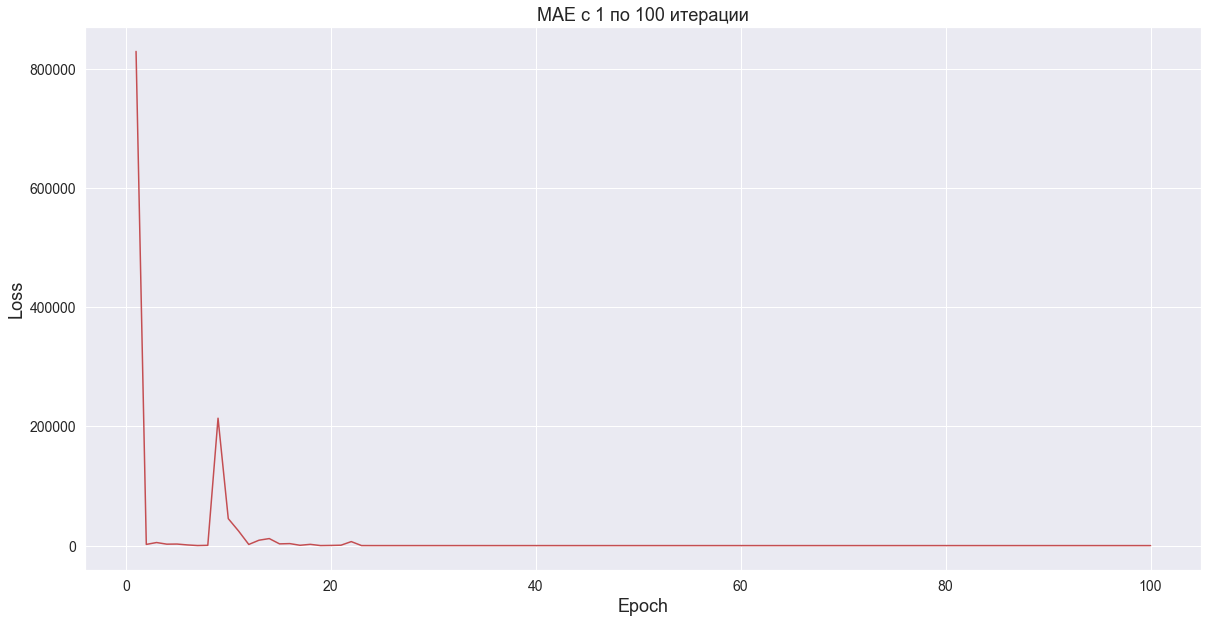

In [106]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1, len(hystory.history['loss'])+1, step=1), hystory.history['loss'], color='r')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('MAE с 1 по 100 итерации', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

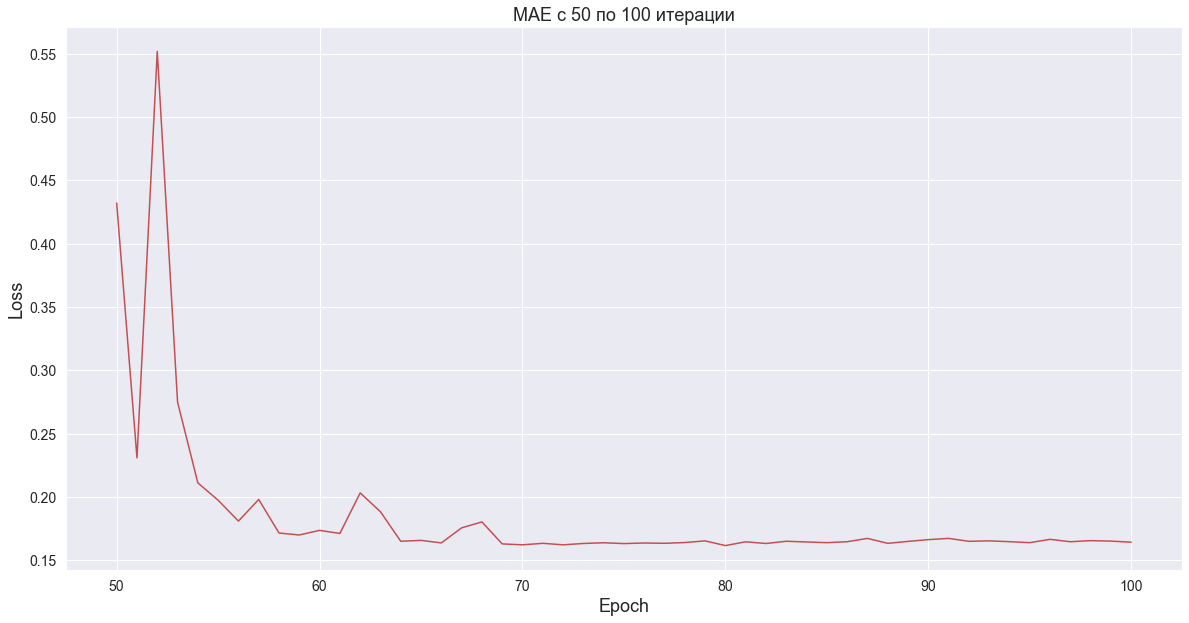

In [107]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(50, len(hystory.history['loss'])+1, step=1), hystory.history['loss'][49:], color='r')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('MAE с 50 по 100 итерации', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

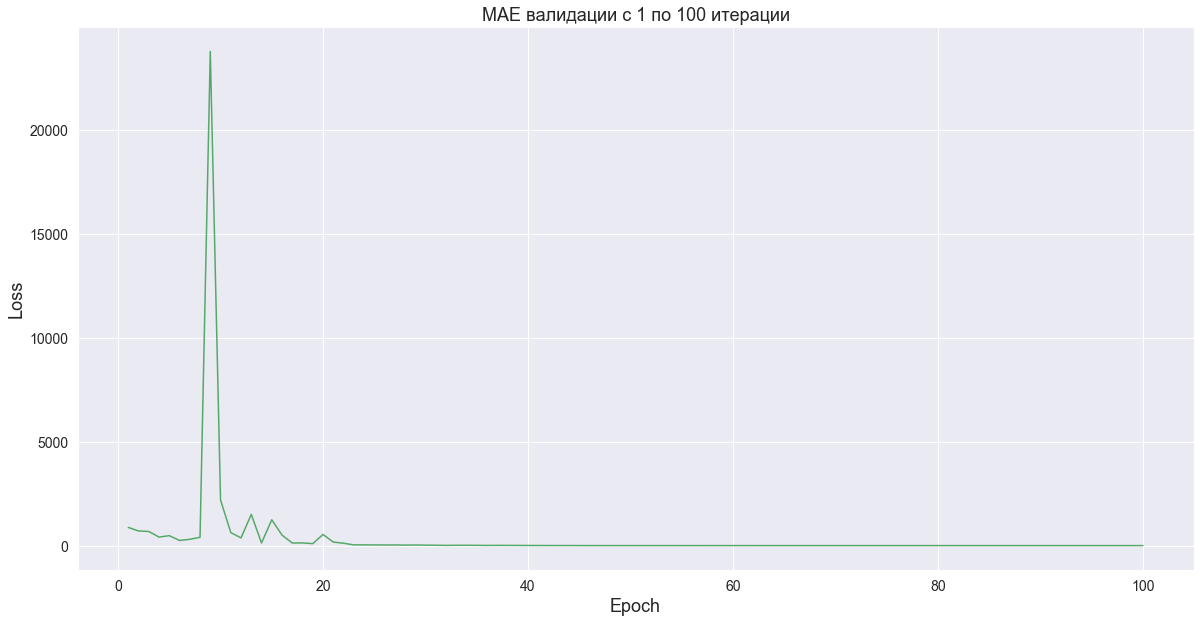

In [108]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1, len(hystory.history['val_loss'])+1, step=1), hystory.history['val_loss'], color='g')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('MAE валидации с 1 по 100 итерации', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

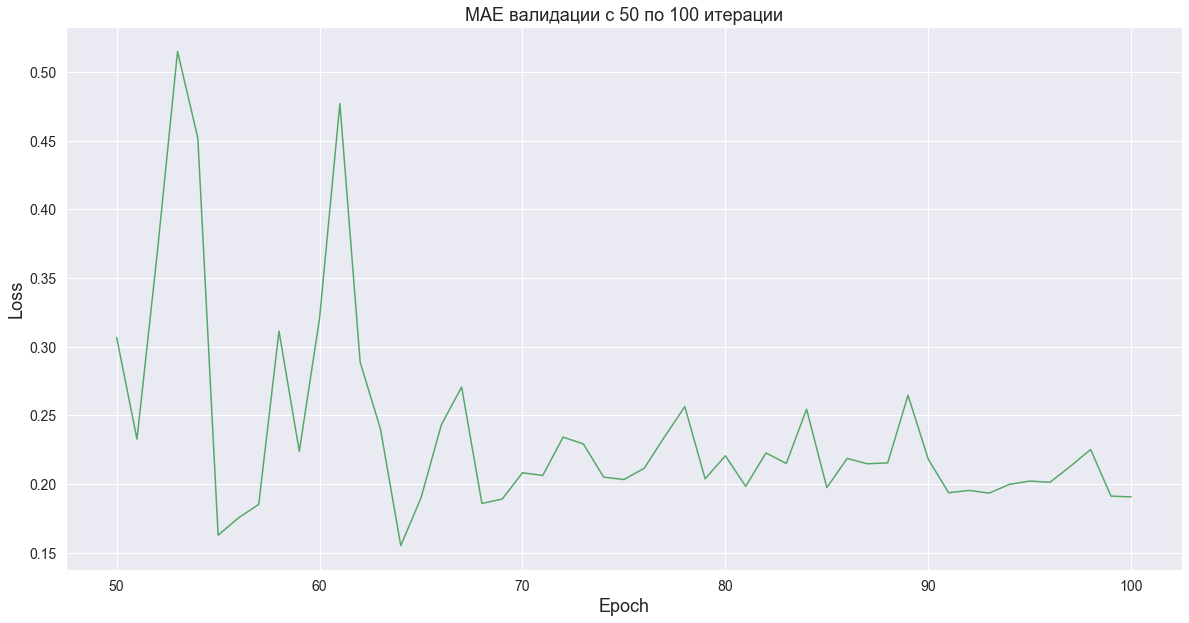

In [109]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(50, len(hystory.history['val_loss'])+1, step=1), hystory.history['val_loss'][49:], color='g')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('MAE валидации с 50 по 100 итерации', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

## Вывод
Лучшей моделью среди выше использованных оказалась модель GradientBoostingRegressor со следующими результатами:
- Средняя правильность перекрестной проверки: 0.901
- MAE: 0.0870
- RMSE: 0.1217
- R2 0.9098

С помощью метода главных компонент была уменьшена разрядность до 100. Линейная регрессия, обученная на получившехся данных также показала высокий результат:
- Средняя правильность перекрестной проверки: 0.866
- MAE: 0.0967
- RMSE: 0.1338
- R2 0.8908

Нейронные сети также показали высокий результат. Дальнейшая настройка модели могла бы улучшить его.

Ниже представлены оценки параметров моделью GradientBoostingRegressor. Выделенные признаки:
- OverallQual
- YearBuilt
- GrLivArea
- TotalBsmtSF


Text(0.5, 1.0, 'GradientBoostingRegressor feature importances >0.001')

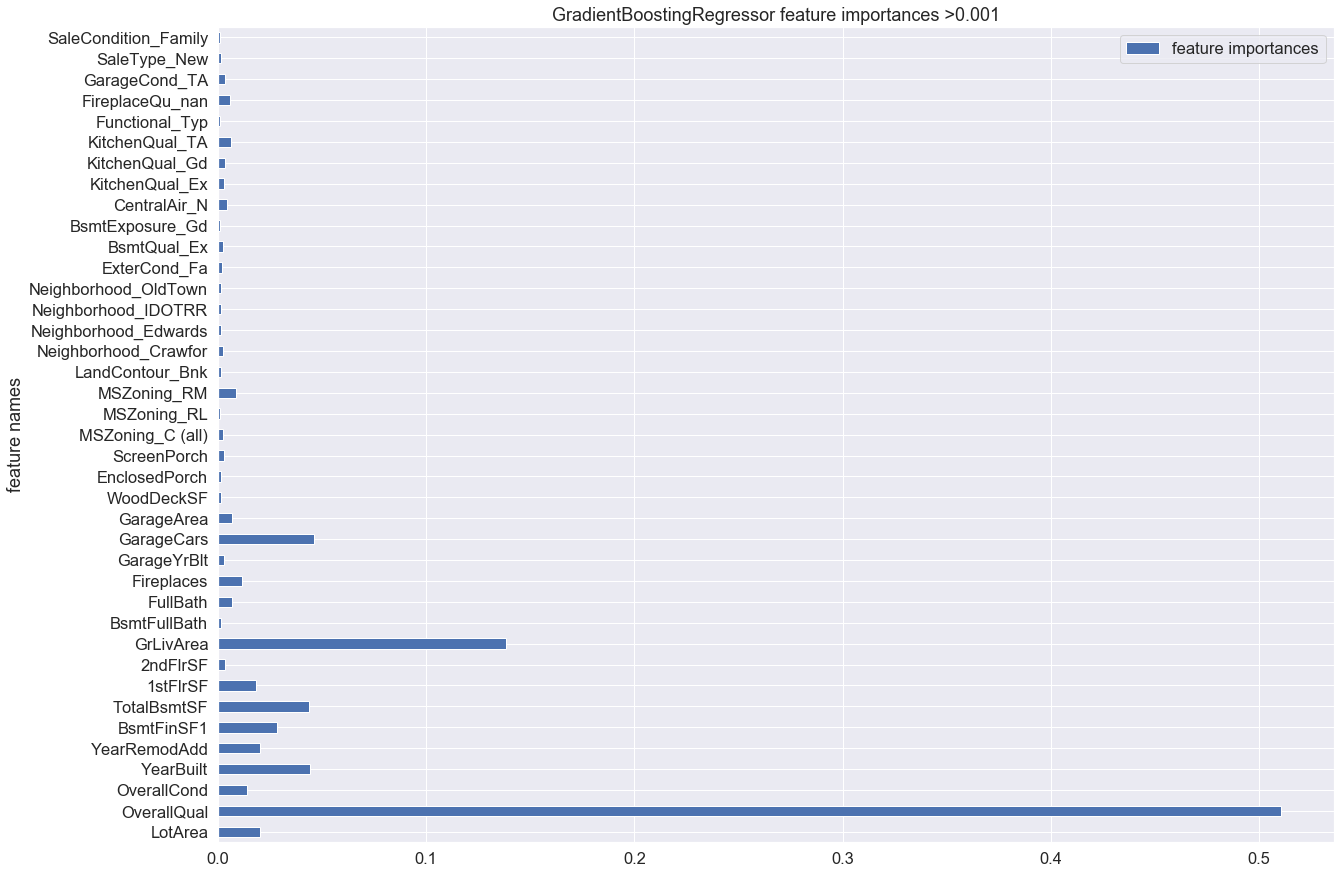

In [119]:
sns.set(font_scale=1.5)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'feature importances':grad_boost.named_steps['estimator'].feature_importances_})
df_to_plot[df_to_plot['feature importances']>0.001].plot.barh(x='feature names', y='feature importances', figsize=(20, 15))
plt.title('GradientBoostingRegressor feature importances >0.001')